In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
df_train = pd.read_csv("train_reviews.csv")

In [3]:
df_train.head()

,review_title,review_body,review_date,review_rating,number_of_photos,helpful_vote,reviewer_ID,fake_asin,fake_review,product_ID,review_ID
0,Super product,"My husband has a hard time sleeping, the very ...",2020-04-13,5,0,0,380263,1,1,389,34510
1,Very sturdy,Rving,2020-08-29,5,0,0,845137,0,0,99,381688
2,Five Stars,has dramatically improved my toe nail appearances,2018-02-27,5,0,0,659759,0,0,107,417933
3,Great portable irrigator,I recently got braces and needed this for work...,2012-05-16,5,0,1,73493,0,0,66,166465
4,Four Stars,The Salad Shooter works great and saves time.,2015-01-05,4,0,0,714841,0,0,14,289006


In [4]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = ((df_train.isnull().sum()/df_train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
review_title,357,0.090895
review_body,44,0.011203
review_date,0,0.000000
review_rating,0,0.000000
number_of_photos,0,0.000000
helpful_vote,0,0.000000
reviewer_ID,0,0.000000
fake_asin,0,0.000000
fake_review,0,0.000000
product_ID,0,0.000000


In [5]:
df_train=df_train.dropna(subset='review_body', axis=0, how='any')

In [12]:
df_train.shape

(392716, 11)

In [6]:
df_price=pd.read_csv("price_data.csv")
df_rank=pd.read_csv("rank_data.csv")



In [7]:
import seaborn as sns

In [8]:
df_price.shape

(77917, 3)

In [9]:
df_rank = df_rank.rename(columns={'date': 'review_date'})

In [10]:
df_train_rank=pd.merge(df_train,df_rank, on=['review_date', 'product_ID'], how='inner')

In [11]:
df_train_rank.shape

(275733, 12)

<AxesSubplot: xlabel='fake_review', ylabel='count'>

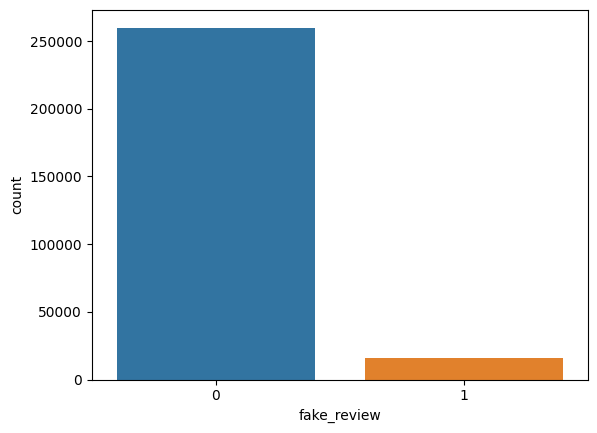

In [12]:
import seaborn as sns
sns.countplot(x=df_train_rank['fake_review'])

In [13]:
df_train_rank['fake_review'].value_counts()

0    259938
1     15795
Name: fake_review, dtype: int64

In [14]:
print(len(df_train_rank["product_ID"].unique()))

446


In [15]:
df_train_rank_fake= df_train_rank[df_train_rank['fake_review']==1]

In [16]:
df_train_rank_non_fake= df_train_rank[df_train_rank['fake_review']==0]

In [17]:
print(df_train_rank_fake.shape)
print(df_train_rank_non_fake.shape)

(15795, 12)
(259938, 12)


In [18]:
non_fake_downsampled= df_train_rank_non_fake.sample(df_train_rank_fake.shape[0], random_state=42)
non_fake_downsampled.shape

(15795, 12)

In [19]:
df_balanced=pd.concat([non_fake_downsampled, df_train_rank_fake])

<AxesSubplot: xlabel='fake_review', ylabel='count'>

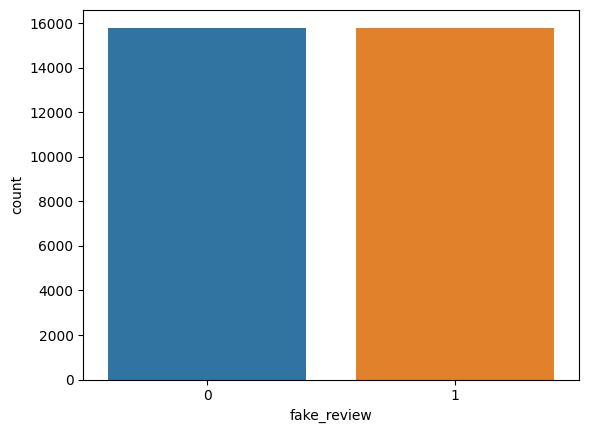

In [20]:
sns.countplot(x=df_balanced['fake_review'])

In [21]:
df_balanced.head()

,review_title,review_body,review_date,review_rating,number_of_photos,helpful_vote,reviewer_ID,fake_asin,fake_review,product_ID,review_ID,rank
98414,Four Stars,"Gave as a gift, but never heard anything back,...",2018-03-09,4,0,0,979093,0,0,291,101755,80
258017,Easy fill.....,Handy and cute. I love the design and spout.,2019-12-19,5,0,0,425076,0,0,87,54405,271
214183,Mostly happy,I bought one of these and it was great very ha...,2020-02-05,3,0,0,1018676,0,0,238,229627,2244
178795,Keeps curls tight,Perfect heat,2019-03-14,5,0,0,402085,0,0,72,288760,20842
215713,Just a so so product.,It is hard to read from any distance more than...,2017-02-09,3,0,0,812792,0,0,145,13026,19050


In [22]:
import os
import string
import datetime
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import tensorflow.keras as keras
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import os.path
import shutil

In [24]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Input,concatenate,Activation, Dense, Dropout, Embedding, Flatten,Bidirectional, LSTM
from keras.models import Model
from keras.initializers import Constant
from keras.optimizers import Adam

In [25]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [28]:

features = ["review_body", "review_rating", "fake_review", "fake_asin"]
df_balanced= df_balanced[features]
df_balanced.head()

,review_body,review_rating,fake_review,fake_asin
98414,"Gave as a gift, but never heard anything back,...",4,0,0
258017,Handy and cute. I love the design and spout.,5,0,0
214183,I bought one of these and it was great very ha...,3,0,0
178795,Perfect heat,5,0,0
215713,It is hard to read from any distance more than...,3,0,0


In [29]:
def remove_punctuation(txt):
  #We lower-case every word 
  text_lower = "".join([c.lower() for c in txt])
  #Then we remove punctuations
  txt_nonpunct = "".join([c for c in text_lower if c not in string.punctuation])
  return txt_nonpunct

In [30]:
df_balanced['review_body'] = df_balanced['review_body'].apply(lambda x: remove_punctuation(x))
     

In [31]:
df_balanced.head()

,review_body,review_rating,fake_review,fake_asin
98414,gave as a gift but never heard anything back b...,4,0,0
258017,handy and cute i love the design and spout,5,0,0
214183,i bought one of these and it was great very ha...,3,0,0
178795,perfect heat,5,0,0
215713,it is hard to read from any distance more than...,3,0,0


In [32]:
train_size=0.7

X = df_balanced.copy()

# In the first step we will split the data in training and remaining dataset
X_train, X_rem= train_test_split(X, train_size=train_size)

# # Now since we want the valid and test size to be equal (10% each of overall data). 
# # we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test = train_test_split(X_rem, test_size=0.5)

In [33]:
train_rating = X_train.pop('review_rating')
valid_rating = X_valid.pop('review_rating')
test_rating = X_test.pop('review_rating')


In [36]:
train_asin = X_train.pop('fake_asin')
valid_asin = X_valid.pop('fake_asin')
test_asin = X_test.pop('fake_asin')

In [37]:
train_label = X_train.pop('fake_review')
valid_label = X_valid.pop('fake_review')
test_label = X_test.pop('fake_review')

In [38]:
oov_token = ""
max_length = 100
padding_type = "post"
truncation_type="post"

In [40]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(X_train.review_body)
vocab_size = len(tokenizer.word_index)+1
print('Vocab Size is ',vocab_size)

Vocab Size is  24796


In [45]:
X_train_sequences = tokenizer.texts_to_sequences(X_train.review_body)
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=truncation_type)

#Tokenize and padding for the "REVIEW_TEXT" column of the validation dataset
X_val_sequences = tokenizer.texts_to_sequences(X_valid.review_body)
X_val_padded = pad_sequences(X_val_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=truncation_type)

#Tokenize and padding for the "REVIEW_TEXT" column of the test dataset
X_test_sequences = tokenizer.texts_to_sequences(X_test.review_body)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=truncation_type)


In [48]:
documents = []
# We split each text of the "REVIEW_TEXT" column
for _text in X_train.review_body:    
    documents.append((_text.split(" ")))
     

In [50]:
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 64
W2V_MIN_COUNT = 5
W2V_SG = 1 

#We get the Word2Vec model from gensim
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            sg = W2V_SG,
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

#We build the vocabulary
w2v_model.build_vocab(documents)

In [51]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


(38221636, 55009792)

In [52]:
embedding_matrix = np.zeros((vocab_size , W2V_SIZE))
for word , i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(24796, 100)


In [53]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            max_length,
                            embeddings_initializer= Constant(embedding_matrix),
                            trainable=False)

In [71]:
review_branch_ip = Input(shape=(100,), name='Review_input')
review_branch = embedding_layer(review_branch_ip)
review_branch = Dropout(0.2)(review_branch)
review_branch = Bidirectional(
    LSTM(64, dropout=0.2,recurrent_dropout=0)
)(review_branch)
review_branch = Dense(64,activation='relu')(review_branch)
review_branch_op = Dense(16, activation='relu')(review_branch)


rating_branch_ip = Input(shape=(1,), name='Rating_input')
rating_branch = Dense(8,activation='relu')(rating_branch_ip)
rating_branch = Dropout(0.2)(rating_branch)
rating_branch_op = Dense(16,activation='relu')(rating_branch)




fake_asin_branch_ip = Input(shape=(1,), name='fake_asin_input')
fake_asin_branch = Dense(8,activation='relu')(fake_asin_branch_ip)
fake_asin_branch = Dropout(0.2)(fake_asin_branch)
fake_asin_branch_op = Dense(16,activation='relu')(fake_asin_branch)


concat = concatenate([review_branch_op, rating_branch_op, fake_asin_branch_op], name='Concatenate')


final_op = Dense(8, activation='relu')(concat)
final_output = Dense(1,activation='sigmoid')(final_op)

model = Model(inputs=[review_branch_ip,rating_branch_ip,fake_asin_branch_ip], outputs=final_output,
                  name='Final_output')

In [64]:
! pip install tf-nightly

  Using cached tf_nightly-2.13.0.dev20230405-cp311-cp311-win_amd64.whl (2.1 kB)
  Using cached tf_nightly-2.13.0.dev20230404-cp311-cp311-win_amd64.whl (2.1 kB)
  Using cached tf_nightly_intel-2.13.0.dev20230404-cp311-cp311-win_amd64.whl (178.1 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\aravi\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



In [72]:
model.compile(optimizer=Adam(clipvalue=0.5) , 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

In [73]:
model.summary()

Model: "Final_output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Review_input (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     2479600     ['Review_input[0][0]']           
                                                                                                  
 dropout_3 (Dropout)            (None, 100, 100)     0           ['embedding[1][0]']              
                                                                                                  
 Rating_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                       

In [74]:
stop_early_model = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit([X_train_padded,train_rating,train_asin], train_label, batch_size=32,epochs=10, validation_data=([X_val_padded,valid_rating,valid_asin], valid_label),callbacks=[stop_early_model])

Epoch 1/10
692/692 [==============================] - 29s 36ms/step - loss: 0.6194 - precision: 0.7651 - recall: 0.5160 - val_loss: 0.6015 - val_precision: 0.7894 - val_recall: 0.5392
Epoch 2/10
692/692 [==============================] - 23s 34ms/step - loss: 0.6032 - precision: 0.7934 - recall: 0.5379 - val_loss: 0.6012 - val_precision: 0.7894 - val_recall: 0.5392
Epoch 3/10
692/692 [==============================] - 24s 34ms/step - loss: 0.6016 - precision: 0.7934 - recall: 0.5383 - val_loss: 0.5975 - val_precision: 0.7894 - val_recall: 0.5392
Epoch 4/10
692/692 [==============================] - 24s 34ms/step - loss: 0.5973 - precision: 0.7918 - recall: 0.5400 - val_loss: 0.5973 - val_precision: 0.7894 - val_recall: 0.5392
Epoch 5/10
692/692 [==============================] - 26s 37ms/step - loss: 0.5953 - precision: 0.7888 - recall: 0.5421 - val_loss: 0.5964 - val_precision: 0.7883 - val_recall: 0.5435
Epoch 6/10
692/692 [==============================] - 24s 35ms/step - loss: 0.59

In [77]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.59637314>,
 'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.78814083>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.54136616>}

In [76]:
result = model.get_metrics_result()

In [84]:
precision = result['precision'].numpy()
recall = result['recall'].numpy()
f1_score = 2 * precision * recall / (precision + recall)
print("F1 Score is ", f1_score)

F1 Score is  0.6418511201383663


In [108]:
df_test = pd.read_csv("test_reviews.csv")
df_raw = df_test.copy()

In [86]:
df_test.head()

,review_title,review_body,review_date,review_rating,number_of_photos,helpful_vote,reviewer_ID,fake_asin,product_ID,review_ID
0,Fit of phone 7+,I have the iPhone 7+ and it says it fits this....,2019-09-04,4,1,0,440934,0,281,427196
1,Sturdy and simply,This product comes assembled and works simply ...,2020-08-22,5,0,0,1044859,0,17,205467
2,Great product,I really like this product because 1st my kids...,2020-05-29,5,0,0,377805,1,342,202189
3,Item got good reviews but ...,I couldn't get the product to stay in my ear. ...,2019-09-07,1,0,2,747580,0,212,56726
4,Great Sheet Protectors - Love the Easy Loading,These sheet protectors were the perfect weight...,2012-10-05,5,0,0,1170571,0,10,409558


In [87]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = ((df_test.isnull().sum()/df_test.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
review_title,33,0.075619
review_body,3,0.006874
review_date,0,0.000000
review_rating,0,0.000000
number_of_photos,0,0.000000
helpful_vote,0,0.000000
reviewer_ID,0,0.000000
fake_asin,0,0.000000
product_ID,0,0.000000
review_ID,0,0.000000


In [88]:
df_test['review_body'].fillna("empty review", inplace = True)

In [89]:
df_test.shape

(43640, 10)

In [91]:
features = ["review_body", "review_rating", "fake_asin"]
df_test= df_test[features]

In [92]:
df_test.head()

,review_body,review_rating,fake_asin
0,I have the iPhone 7+ and it says it fits this....,4,0
1,This product comes assembled and works simply ...,5,0
2,I really like this product because 1st my kids...,5,1
3,I couldn't get the product to stay in my ear. ...,1,0
4,These sheet protectors were the perfect weight...,5,0


In [93]:
df_test['review_body'] = df_test['review_body'].apply(lambda x: remove_punctuation(x))

C:\Users\aravi\AppData\Local\Temp\ipykernel_17328\721627641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['review_body'] = df_test['review_body'].apply(lambda x: remove_punctuation(x))


In [94]:
df_test.head()

,review_body,review_rating,fake_asin
0,i have the iphone 7 and it says it fits this i...,4,0
1,this product comes assembled and works simply ...,5,0
2,i really like this product because 1st my kids...,5,1
3,i couldnt get the product to stay in my ear t...,1,0
4,these sheet protectors were the perfect weight...,5,0


In [95]:
X_test = df_test.copy()

In [96]:
unseen_rating = X_test.pop('review_rating')
unseen_asin = X_test.pop('fake_asin')

In [97]:
X_test_sequences = tokenizer.texts_to_sequences(X_test.review_body)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=truncation_type)

In [99]:
X_train_padded[0:12]

array([[11160,   201,    43, ...,     0,     0,     0],
       [   38,    59,     3, ...,     0,     0,     0],
       [   20,     7,   152, ...,     0,     0,     0],
       ...,
       [   11,   257,    69, ...,     0,     0,     0],
       [    3,    33,     2, ...,     0,     0,     0],
       [   83,   132,    28, ...,     0,     0,     0]])

In [100]:
X_test_padded[0:12]

array([[   3,   17,    2, ...,    0,    0,    0],
       [   9,   30,  214, ...,    0,    0,    0],
       [   3,   54,   33, ...,    0,    0,    0],
       ...,
       [   2,  125,   38, ...,    0,    0,    0],
       [  19,  239,   11, ...,    0,    0,    0],
       [   3,   94, 2100, ...,    0,    0,    0]])

In [103]:
results = model.predict([X_test_padded, unseen_rating, unseen_asin])

1364/1364 [==============================] - 24s 16ms/step


In [110]:
df_results = df_raw.copy()

In [111]:
df_results = df_results[['review_ID']]

In [113]:
df_results['fake_review'] = results
df_results.head()

,review_ID,fake_review
0,427196,0.351940
1,205467,0.330039
2,202189,0.742104
3,56726,0.295513
4,409558,0.219790


In [116]:
df_results['fake_review'] = df_results['fake_review'].apply(lambda x: 1 if(x>=0.5) else 0)

In [117]:
df_results.head()

,review_ID,fake_review
0,427196,0
1,205467,0
2,202189,1
3,56726,0
4,409558,0


In [119]:
df_results.to_csv("Predictions_BiLSTM.csv")